In [1]:
import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pyarrow.parquet as pq

import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, GRU
from keras.models import load_model

plt.rcParams['axes.grid'] = True

In [2]:
root_dir = 'C:/Users/delst/OneDrive/Desktop/Code/Workspace/Crypto_V2'
sys.path.append(root_dir)

from A_Main.Configurations.setup_env import setup_environment
config = setup_environment(root_dir)

In [3]:
from Modularisation.feature_eng import FeatureEngineer

---

In [4]:
cryptos = ['BTC']
files = os.path.join(config.sdo_parq, 'BTCUSDT_raw.parquet')
df = pq.read_table(files).to_pandas()
df.drop(columns=['SYMBOL'], inplace=True)

In [5]:
df.head()

,OPEN,HIGH,LOW,CLOSE,VOLUME,QUOTE_ASSET_VOLUME,NUMBER_OF_TRADES,TAKER_BUY_BASE_ASSET_VOLUME,TAKER_BUY_QUOTE_ASSET_VOLUME,TARGET
OPEN_TIME,,,,,,,,,,
2017-09-16 10:00:00,3753.29,3753.29,3470.66,3480.00,175.251826,627740.727773,778,58.976979,209869.879391,0.393885
2017-09-16 11:00:00,3490.00,3678.22,3490.00,3630.06,113.728279,409919.978386,475,68.053148,246000.247708,0.390215
2017-09-16 12:00:00,3630.06,3667.99,3565.47,3630.00,51.172541,185265.726418,347,23.788116,86067.342374,0.360434
2017-09-16 13:00:00,3610.00,3729.99,3531.01,3674.98,60.480745,219448.905188,413,36.841835,134235.540313,0.398650
2017-09-16 14:00:00,3674.98,3800.00,3630.00,3630.00,58.984953,218953.333668,664,14.245711,53040.500428,0.451718


---

In [6]:
df, df_test = train_test_split(df, test_size=0.2, shuffle=False)

In [7]:
feature_cols_for_eng = ['OPEN','HIGH','LOW','CLOSE','VOLUME']
ror_col = 'CLOSE'

In [8]:
def apply_feature_engineering(
    df:pd.DataFrame,
    feature_cols_for_eng:list,
    ror_col:str
    ):
    
    feature_engineer = FeatureEngineer(
        df,
        feature_cols_for_eng,
        config.mmean_periods,
        ror_col
    )

    df = feature_engineer.get_rate_of_return()
    df = feature_engineer.get_market_means_ratios()
    df = feature_engineer.get_sma_ema()
    df = feature_engineer.get_percentage_change()
    
    return df

apply_feature_engineering(df, feature_cols_for_eng, ror_col)
apply_feature_engineering(df_test, feature_cols_for_eng, ror_col)

,OPEN,HIGH,LOW,CLOSE,VOLUME,QUOTE_ASSET_VOLUME,NUMBER_OF_TRADES,TAKER_BUY_BASE_ASSET_VOLUME,TAKER_BUY_QUOTE_ASSET_VOLUME,TARGET,...,LOW_ema,CLOSE_sma,CLOSE_ema,VOLUME_sma,VOLUME_ema,OPEN_pct_change,HIGH_pct_change,LOW_pct_change,CLOSE_pct_change,VOLUME_pct_change
OPEN_TIME,,,,,,,,,,,,,,,,,,,,,
2022-01-27 16:00:00,36639.43,36787.77,36327.13,36528.86,1843.62877,6.735977e+07,49362,895.84934,3.273223e+07,0.445180,...,36327.130000,40257.191986,36528.860000,1762.927083,1843.628770,-0.003018,-0.005104,-0.004562,-0.006757,-0.189705
2022-01-27 17:00:00,36528.85,36600.00,36161.41,36282.03,1493.88279,5.423506e+07,44022,753.80997,2.736865e+07,0.454244,...,36326.670305,40257.191986,36528.175312,1762.927083,1842.658601,-0.003018,-0.005104,-0.004562,-0.006757,-0.189705
2022-01-27 18:00:00,36282.02,36345.76,36022.07,36215.49,1606.52202,5.803644e+07,43875,785.74886,2.838682e+07,0.457998,...,36325.825367,40257.191986,36527.307946,1762.927083,1842.003576,-0.006757,-0.006946,-0.003853,-0.001834,0.075400
2022-01-27 19:00:00,36215.49,36327.72,35883.82,36209.20,1971.02943,7.124669e+07,50461,1006.06489,3.637845e+07,0.519622,...,36324.599277,40257.191986,36526.425539,1762.927083,1842.361484,-0.001834,-0.000496,-0.003838,-0.000174,0.226892
2022-01-27 20:00:00,36209.19,36435.70,35557.96,35583.50,2461.62784,8.859789e+07,58612,1073.48806,3.865635e+07,0.471609,...,36322.472677,40257.191986,36523.809934,1762.927083,1844.079282,-0.000174,0.002972,-0.009081,-0.017280,0.248905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-28 19:00:00,23481.63,23492.84,23205.06,23264.36,18237.24695,4.254090e+08,530354,8778.67607,2.047670e+08,0.448246,...,22980.663503,23288.049153,23063.977651,12774.414002,12584.032107,-0.001882,-0.002427,-0.009891,-0.009253,0.714836
2023-02-28 20:00:00,23263.38,23343.55,23166.35,23272.05,15233.07563,3.543993e+08,423062,7509.37862,1.747199e+08,0.470401,...,22981.178583,23287.456653,23064.554828,12773.837411,12591.380356,-0.009294,-0.006355,-0.001668,0.000331,-0.164727
2023-02-28 21:00:00,23270.59,23277.98,23020.97,23139.89,19752.93941,4.570602e+08,544036,9619.11094,2.225759e+08,0.468764,...,22981.288962,23286.547889,23064.763802,12788.353905,12611.245984,0.000310,-0.002809,-0.006275,-0.005679,0.296714


---

In [9]:
# Define the proportion for the split
test_proportion = 0.2
split_index = int(df.shape[0] * (1-test_proportion))

# Create training and testing dataframes
train_df = df[:split_index]
test_df = df[split_index:]

# Fit the scaler to the training data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(train_df[['CLOSE']].values)

# Scale the training and testing data
train_features = scaler.transform(train_df[['CLOSE']].values)
test_features = scaler.transform(test_df[['CLOSE']].values)

# Prepare the inputs for LSTM
def prepare_data(scaled_features, n_past):
    X, y = [], []
        
    for i in range(n_past, len(scaled_features)):
        X.append(scaled_features[i - n_past:i, 0])
        y.append(scaled_features[i, 0])

    return np.array(X), np.array(y)

n_future = 48  # N steps in future to predict
n_past = 48  # N past steps used to predict future

# Prepare training data
X_train, y_train = prepare_data(train_features, n_past)

# Prepare testing data
X_test, y_test = prepare_data(test_features, n_past)

In [10]:
# Define the model
model = Sequential()

# LSTM layers
model.add(LSTM(units=64, return_sequences=True, input_shape=(X_train.shape[1], 1), activation='linear'))
model.add(Dropout(0.4))

model.add(LSTM(units=32, return_sequences=True, activation='linear'))
model.add(Dropout(0.4))

model.add(LSTM(units=32, return_sequences=True, activation='linear'))
model.add(Dropout(0.4))

model.add(LSTM(units=16, return_sequences=True, activation='linear'))
model.add(Dropout(0.2))

model.add(LSTM(units=16, activation='linear'))
model.add(Dropout(0.2))

# The output layer
model.add(Dense(units=1))

# Compiling the RNN
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
952/952 [==============================] - 117s 114ms/step - loss: 0.0015
Epoch 2/10
952/952 [==============================] - 109s 114ms/step - loss: 8.2316e-04
Epoch 3/10
952/952 [==============================] - 109s 114ms/step - loss: 7.2338e-04
Epoch 4/10
952/952 [==============================] - 108s 114ms/step - loss: 6.8417e-04
Epoch 5/10
952/952 [==============================] - 104s 109ms/step - loss: 6.3813e-04
Epoch 6/10
952/952 [==============================] - 104s 109ms/step - loss: 6.5317e-04
Epoch 7/10
952/952 [==============================] - 105s 111ms/step - loss: 6.2295e-04
Epoch 8/10
952/952 [==============================] - 104s 110ms/step - loss: 6.0991e-04
Epoch 9/10
952/952 [==============================] - 104s 110ms/step - loss: 5.9303e-04
Epoch 10/10
952/952 [==============================] - 102s 107ms/step - loss: 5.6476e-04


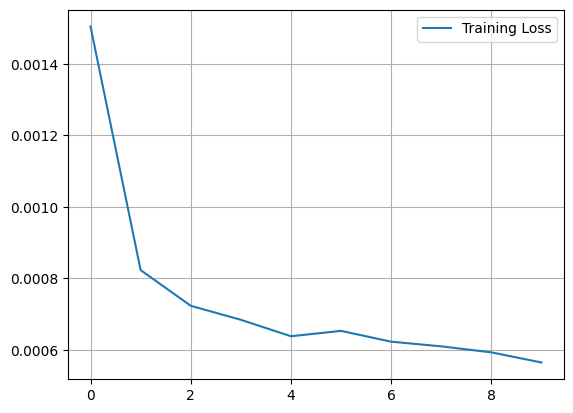

In [11]:
# visual to check for overfitting
plt.plot(model.history.history['loss'], label='Training Loss')
plt.legend()
plt.show()

---

When saving a model, common practice is to include relevant details in the filename, such as:

- Model Type
- Dataset Name
- Date of Training
- Model Performance
- Hierarchical Data Format version 5

For example: LSTM_BTC_20230807_accuracy0.95.h5

In [12]:
# Save the model using Keras's save() function
model.save(os.path.join(config.model_dir, 'LSTM_BTC_20230807_accuracy0.95.h5'))

In [13]:
# Load the model
# model = load_model(os.path.join(config.model_dir, 'LSTM_BTC_20230807_accuracy0.95.h5'))

---